In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
import scipy
import sklearn.datasets
import matplotlib.pyplot as plt
import random
%matplotlib inline

 Создадим класс LinearRegressor
 Нахождение вектора оптимальных весов $w$ может быть сделано и аналитически.
Мы хотим найти такой вектор весов $w$, чтобы вектор $y$, соответствующий целевому признаку, получался умножением матрицы $X$ (состоящей из всех признаков объектов обучающей выборки, кроме целевого) на вектор весов $w$. То есть, чтобы выполнялось матричное уравнение:
$$y = Xw$$
Домножением слева на $X^T$ получаем:
$$X^Ty = X^TXw$$
Это хорошо, поскольку теперь матрица $X^TX$ - квадратная, и можно найти решение (вектор $w$) в виде:
$$w = {(X^TX)}^{-1}X^Ty$$
Матрица ${(X^TX)}^{-1}X^T$ - [*псевдообратная*](https://ru.wikipedia.org/wiki/Псевдообратная_матрица) для матрицы $X$. В NumPy такую матрицу можно вычислить с помощью функции [numpy.linalg.pinv](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.pinv.html).

Однако, нахождение псевдообратной матрицы - операция вычислительно сложная и нестабильная в случае малого определителя матрицы $X$ (проблема мультиколлинеарности). 
На практике лучше находить вектор весов $w$ решением матричного уравнения 
$$X^TXw = X^Ty$$Это может быть сделано с помощью функции [numpy.linalg.solve](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linalg.solve.html).

Но все же на практике для больших матриц $X$ быстрее работает градиентный спуск, особенно его стохастическая версия.

In [106]:
class LinearRegressor():
    weights = []
    def __init__(self):
        self.weights = []
    def fit(self, X, y):
        self.weights = scipy.linalg.solve(np.dot(np.transpose(X), X), np.dot(np.transpose(X), y))
        #self.weights = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X), X)) , np.transpose(X)), y)
    def predict(self, X):
        return np.dot(X, self.weights)

In [107]:
fires = pd.read_csv('/Users/semenfedotov/Downloads/forestfires.csv')

Преобразуем наш датасет так, что столбец day стал теперь индикатором выходного дня(категориальный признак, sat and sun - выходные)
Далее , заменим месяца на времена года:
<ul>
    <li>autumn - 1 столбец </li>
    <li>spring - 2 столбец </li>
    <li>summer - 3 столбец </li>
    <li>winter - 4 столбец </li>
</ul>

In [108]:
def is_weekend(day):
    if day in ('sat', 'sun'):
        return 1
    else:
        return 0

In [109]:
def season(month):
    if month in ('jun', 'jul', 'aug'):
        return 'summer'
    if month in ('sep', 'oct', 'nov'):
        return 'autumn'
    if month in ('dec', 'jan', 'feb'):
        return 'winter'
    if month in ('mar', 'apr', 'may'):
        return 'spring'

In [110]:
fires['day'] = map(lambda day : is_weekend(day), fires.day)

In [111]:
fires.rename(columns = ({ 'day' : 'weekend'}), inplace=True)

Добавим бинарные признаки(4 столбца) отвечающие, каким сезоном является

In [112]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

categorial_data = pd.DataFrame(map(lambda month : season(month),fires.month))
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(categorial_data.T.to_dict().values())


In [113]:
encoded_data = encoded_data.astype(int)

In [114]:
seasons = ['autumn','spring','summer','winter']

In [115]:
for ind, season in enumerate(seasons):
    fires[season] = encoded_data[:,ind]

In [116]:
fires.drop(['month'], axis = 1, inplace=True)

Добавляем единичный признак(для свободного коэффициента)

In [117]:
fires['w_0'] = 1

In [118]:
fires.head(5)

,X,Y,weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,autumn,spring,summer,winter,w_0
0,7,5,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,1,0,0,1
1,7,4,0,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1,0,0,0,1
2,7,4,1,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1,0,0,0,1
3,8,6,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,1,0,0,1
4,8,6,1,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,1,0,0,1


Перемешаем наш датасет и разобьем его на X и y(area)

In [119]:
fires_shuffled = fires.sample(frac=1).reset_index(drop=True) 
target = fires_shuffled.area
data = fires_shuffled.drop(['area'], axis=1)
import sklearn.cross_validation

Сделаем разбиение нашего датасета в соотношении 7:3 т.е. 70% на обучение и 30% на тест

In [120]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(data, target, test_size= 0.3)

Построим регрессионну модель и предскажем на тестовой части ответы. Посмотрим на Веса и среднеквадратичную ошибку

In [121]:
algo = LinearRegressor()
algo.fit(X_train.as_matrix(), y_train.as_matrix())
predictions = algo.predict(X_test.as_matrix())

In [122]:
algo.weights

array([  6.89404220e-01,  -7.75954392e-01,   1.41627649e+01,
         3.15809349e-01,   7.87094345e-02,  -4.48060275e-02,
        -9.38967814e-01,   1.30943384e+00,  -4.39404079e-02,
         1.88535625e+00,  -3.46936643e-02,   8.19497831e+01,
         4.70400682e+01,   5.86288505e+01,   6.40984807e+01,
        -9.32784143e+01])

Очень большая ошибка получается, скорее всего данная модель не подходит для решения нашей задачи!!!

In [123]:
import sklearn.metrics
MSE = sklearn.metrics.mean_squared_error(y_test, predictions)

In [124]:
MSE

4178.8665839600799

# With ln(c + x) transformation
Теперь преобразуем данные и проделаем все то же самое, обучим модель и предскажем ответы



In [125]:
c = np.arange(0.1, 10, 0.01) # вот массив различных констант

In [126]:
def invert_eval(evals, c):
    return map(lambda x: np.exp(x) - c, evals) # обратное преобразование нашего преобразования

Код ниже перебирает все константы из списка С и для них делает разбиение датасета(всегда одно и то же)
Далее обучаем модель на преобразованном датасете, находим веса. Считаем среднеквадратичную ошибку. Далее делаем обратное преобразование оценок(весов) и для них делаем предсказания и считаем среднеквадратичную ошибку
////
после того, когда это посчитается, найдем аргминимум во всем списке ошибок и выведем

In [132]:
fires_shuffled = fires.sample(frac=1).reset_index(drop=True)
targets = []
targets_normal = fires_shuffled.area
for i in range(len(c)):
    targets.append(map(lambda x: np.log(c[i] + x),fires_shuffled.area))
data = fires_shuffled.drop(['area'], axis=1)
import sklearn.cross_validation

MSE_ln = []
MSE_inverse = []
for i in range(len(c)):
    X_train_ln, X_test_ln, y_train_ln, y_test_ln = sklearn.cross_validation.train_test_split(data, targets[i - 1], test_size= 0.3, random_state = 0)
    _, _, _, y_test = sklearn.cross_validation.train_test_split(data, targets_normal, test_size= 0.3, random_state = 0)
    algo_ln = LinearRegressor()
    algo_ln.fit(X_train_ln.as_matrix(), y_train_ln)
    predictions_ln = algo_ln.predict(X_test_ln.as_matrix())
    inverse_betas = invert_eval(algo_ln.weights, c[i])
    algo_inv = LinearRegressor()
    algo_inv.weights = inverse_betas
    predictions_inv = algo_inv.predict(X_test_ln.as_matrix())
    MSE_ln.append(sklearn.metrics.mean_squared_error(y_test_ln, predictions_ln))
    MSE_inverse.append(sklearn.metrics.mean_squared_error(y_test, predictions_inv))
    
MSE_inverse[np.argmin(MSE_inverse)], c[np.argmin(MSE_inverse)]

(908.87885875409199, 1.0699999999999996)

Найдя аргминимум в списке из среднеквадратичных ошибок, мы получаем, что лучшей константой для нашего преобразования будет являться c = 1

Напоследок, нарисуем график среднеквадратичной ошибки для предсказанных данных для столбца ln(c + area), для констант, которые вариируются от 0.1 до 10

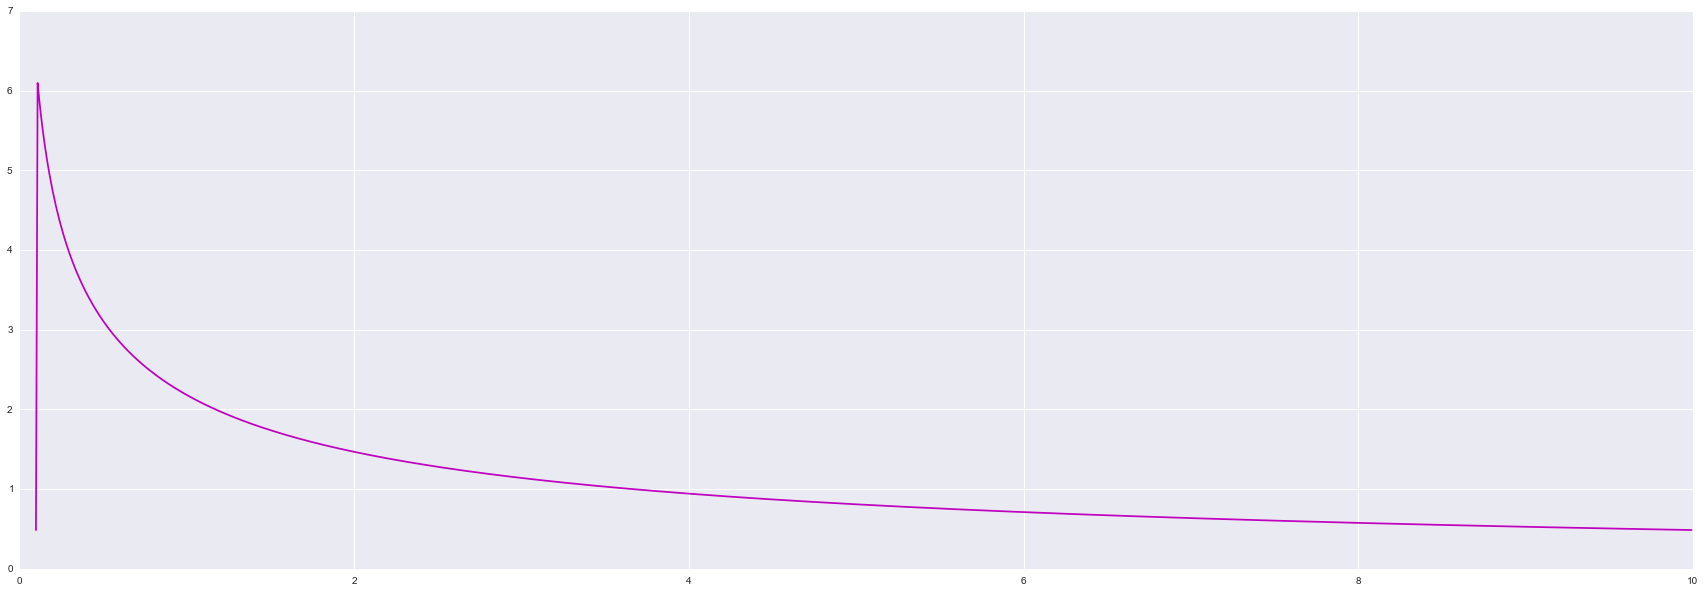

In [128]:
plt.figure(figsize=(30,10))
plt.plot(c, MSE_ln, color = 'm')
plt.show()


Теперь сгенерируем несколько различных  разбиений с константой с = 1 и найдем среднеквадратичные ошибки

In [129]:
MSE_FINAL = []
for i in range(1000):
    X_train_final, X_test_final, y_train_final, y_test_final = sklearn.cross_validation.train_test_split(data, targets_normal, test_size= 0.3)
    algo_final = LinearRegressor()
    algo_final.fit(X_train_final.as_matrix(), y_train_final.as_matrix())
    predictions_final = algo_final.predict(X_test_final)
    error = sklearn.metrics.mean_squared_error(y_test_final, predictions_final)
    MSE_FINAL.append(error)

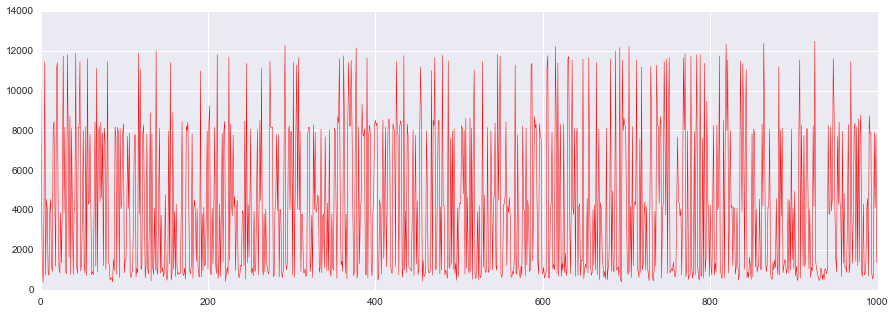

In [130]:
plt.figure(figsize=(15,5))
plt.plot(range(1000), MSE_FINAL, color = 'red', linewidth=0.5)

Видим , что результат очень зависит от перемешивания датасета(оно и понятно, т.к. может попасться , например, чисто зимние месяца, и мы переобучимся на этих данных, т.к. зимой, предполагается меньше пожаров), это связано с тем, что измерения проведены в течение года, а не в один какой-то момент.

А посмотрим на среднее для площади

In [133]:
fires.area.mean()

12.847292069632491

А наши среднеквадратичные ошибки достигают 14000, что совсем недопустимо при таком малом среднем площади

Мы во всех частях , кроме того, когда мы делали MSE ot ln(c + x) , получали ошибку очень большую, Ну а это значит, что для решения этой задачи(предсказать площадь пожара), не подходит применение линейной регрессионной модели. Возможно, лучше использовать полиномиальную модель.